In [1]:
import os
import random

import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
sns.set(style="whitegrid")
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.inspection import permutation_importance

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)


def quick_report_df(df, max_unique=10):
    report = pd.DataFrame({
        'dtype': df.dtypes,
        'n_null': df.isnull().sum(),
        'pct_null': df.isnull().mean(),
        'n_unique': df.nunique()
    })
    display(report)
    for col in df.columns:
        if df[col].nunique() <= max_unique and df[col].dtype != 'float64':
            print(f'Колонка "{col}" - уникальных: {df[col].nunique()} -> {df[col].unique()[:max_unique]}')


def basic_classification_scores(y_true, y_pred, y_proba=None):
    out = {}
    out['accuracy'] = round(accuracy_score(y_true, y_pred), 3)
    out['precision'] = round(precision_score(y_true, y_pred, average='weighted', zero_division=0), 3)
    out['recall'] = round(recall_score(y_true, y_pred, average='weighted', zero_division=0), 3)
    out['f1_weighted'] = round(f1_score(y_true, y_pred, average='weighted', zero_division=0), 3)
    if y_proba is not None:
        try:
            out['roc_auc'] = round(roc_auc_score(y_true, y_proba, multi_class='ovo', average='macro'), 3)
        except Exception:
            out['roc_auc'] = None
    return out


def plot_class_balance(y, title='Class distribution'):
    counts = pd.Series(y).value_counts().sort_index()
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.barplot(x=counts.index.astype(str), y=counts.values, ax=ax)
    ax.set_title(title)
    ax.set_ylabel('count')
    for i, v in enumerate(counts.values):
        ax.text(i, v + max(counts.values) * 0.01, str(v), ha='center')
    plt.show()

In [2]:
from sklearn.datasets import load_iris
import pandas as pd

iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df["target"] = iris.target

df_small = df.sample(n=50, random_state=RANDOM_SEED).reset_index(drop=True)

df_small.shape


(50, 5)

### смотрим распределение

,dtype,n_null,pct_null,n_unique
sepal length (cm),float64,0,0.0,26
sepal width (cm),float64,0,0.0,19
petal length (cm),float64,0,0.0,24
petal width (cm),float64,0,0.0,18
target,int32,0,0.0,3


Колонка "target" - уникальных: 3 -> [1 0 2]


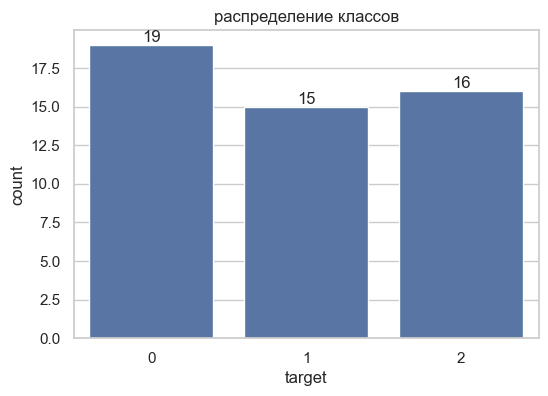

In [3]:
quick_report_df(df_small)
plot_class_balance(df_small["target"], title=('распределение классов'))

### тест трейн

In [4]:
X = df_small.drop("target", axis=1)
y = df_small["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=RANDOM_SEED,
    stratify=y
)

X_train.shape, X_test.shape

((37, 4), (13, 4))

### заполняем пропуски + нормализуем

In [5]:
num_cols = X_train.columns.tolist()

numeric_transform = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transform, num_cols)
    ]
)

preprocess


,transformers,"[('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


### подбираем параметры

In [6]:
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline

pipe_lr = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=500))
])

param_grid_lr = {
    "model__C": [0.01, 0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "model__penalty": ["l2"],
    "model__solver": ["lbfgs"]
}

grid_lr = GridSearchCV(
    pipe_lr,
    param_grid=param_grid_lr,
    cv=5,
    scoring="f1_weighted",
    n_jobs=-1
)
grid_lr.fit(X_train, y_train)
best_lr_grid = grid_lr.best_estimator_


In [13]:
from pprint import pprint

param_dist_lr = {
    "model__C": uniform(0.01, 10),
    "model__penalty": ["l2"],
    "model__solver": ["lbfgs"]
}

rand_lr = RandomizedSearchCV(
    pipe_lr,
    param_distributions=param_dist_lr,
    n_iter=20,
    cv=5,
    scoring="f1_weighted",
    random_state=RANDOM_SEED,
    n_jobs=-1
)
rand_lr.fit(X_train, y_train)
best_lr_rand = rand_lr.best_estimator_

y_pred_grid = best_lr_grid.predict(X_test)
y_proba_grid = best_lr_grid.predict_proba(X_test)
metrics_grid = basic_classification_scores(y_test, y_pred_grid, y_proba_grid)

y_pred_rand = best_lr_rand.predict(X_test)
y_proba_rand = best_lr_rand.predict_proba(X_test)
metrics_rand = basic_classification_scores(y_test, y_pred_rand, y_proba_rand)

print("дискретный подбор")
pprint(metrics_grid)
print(grid_lr.best_params_)
print("\nнепрерывный подбор")
pprint(metrics_rand)
print(rand_lr.best_params_)


дискретный подбор
{'accuracy': 0.923,
 'f1_weighted': 0.922,
 'precision': 0.938,
 'recall': 0.923,
 'roc_auc': 0.99}
{'model__C': 1, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}

непрерывный подбор
{'accuracy': 0.923,
 'f1_weighted': 0.922,
 'precision': 0.938,
 'recall': 0.923,
 'roc_auc': 0.99}
{'model__C': 0.5908361216819946, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}


### неклассическая модель (гауссовая вероятностная классификация)

In [8]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

kernel = 1.0 * RBF(length_scale=1.0)

pipe_gp = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", GaussianProcessClassifier(kernel=kernel, random_state=RANDOM_SEED))
])

pipe_gp.fit(X_train, y_train)

y_pred_gp = pipe_gp.predict(X_test)
y_proba_gp = pipe_gp.predict_proba(X_test)

metrics_gp = basic_classification_scores(y_test, y_pred_gp, y_proba_gp)
metrics_gp


{'accuracy': 0.923,
 'precision': 0.938,
 'recall': 0.923,
 'f1_weighted': 0.922,
 'roc_auc': 0.979}

### интерпретация

In [9]:
class_names = iris.target_names
coeffs = best_lr_rand.named_steps['model'].coef_

for i, col in enumerate(X_train.columns):
    print(f"\nПризнак: {col}")
    for j, class_name in enumerate(class_names):
        print(f"  {class_name}: {coeffs[j, i]:.3f}")



Признак: sepal length (cm)
  setosa: -0.673
  versicolor: 0.295
  virginica: 0.378

Признак: sepal width (cm)
  setosa: 0.700
  versicolor: -0.320
  virginica: -0.380

Признак: petal length (cm)
  setosa: -0.951
  versicolor: 0.036
  virginica: 0.915

Признак: petal width (cm)
  setosa: -0.894
  versicolor: -0.409
  virginica: 1.303


In [10]:
result_lr = permutation_importance(best_lr_rand, X_test, y_test, n_repeats=10, random_state=RANDOM_SEED)
print("Важность признаков для логрега:")
for i, col in enumerate(X_test.columns):
    print(f"  {col}: {result_lr.importances_mean[i]:.4f}")


Важность признаков для логрега:
  sepal length (cm): 0.0385
  sepal width (cm): 0.0000
  petal length (cm): 0.1231
  petal width (cm): 0.1692


In [11]:
result_gp = permutation_importance(pipe_gp, X_test, y_test, n_repeats=10, random_state=RANDOM_SEED)
print("\nВажность признаков для гаусса:")
for i, col in enumerate(X_test.columns):
    print(f"  {col}: {result_gp.importances_mean[i]:.4f}")



Важность признаков для гаусса:
  sepal length (cm): 0.0538
  sepal width (cm): 0.0154
  petal length (cm): 0.2692
  petal width (cm): 0.2231


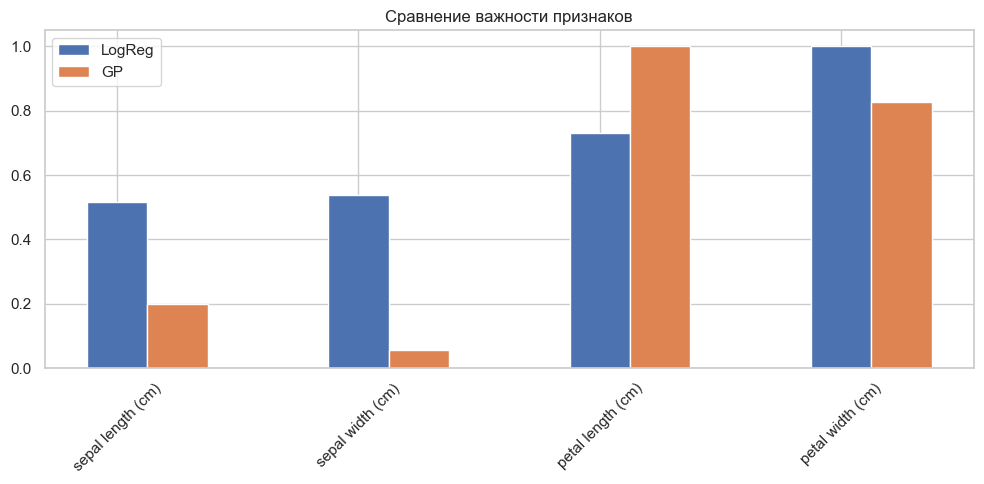

In [12]:
import matplotlib.pyplot as plt
import numpy as np

features = X_train.columns
x = np.arange(len(features))

lr_importance = np.abs(best_lr_rand.named_steps['model'].coef_).max(axis=0)
lr_importance = lr_importance / lr_importance.max()

gp_importance = result_gp.importances_mean
gp_importance = gp_importance / gp_importance.max()

width = 0.25

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x, lr_importance, width, label='LogReg')
ax.bar(x + width, gp_importance, width, label='GP')

ax.set_xticks(x)
ax.set_xticklabels(features, rotation=45)
ax.set_title("Сравнение важности признаков")
ax.legend()
plt.tight_layout()
plt.show()


для обеих моделей ключевыми признаками будут petal length и petal width, sepal length, sepal width влияют меньше